In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.utils as utils
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.utils.tensorboard as tb
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
import os
import shutil

try:
    os.remove("/kaggle/working/fake_images_plates.zip")
except OSError as error:
    print(error)
    
try:
    shutil.rmtree('/kaggle/working/fake_images_plates')
except OSError as error:
    print(error)  

[Errno 2] No such file or directory: '/kaggle/working/fake_images_plates.zip'
[Errno 2] No such file or directory: '/kaggle/working/fake_images_plates'


In [3]:
root='/kaggle/input/images/images_plates'
img_list=os.listdir(root)

print(len(img_list))

1184


In [4]:
batch_size = 32

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 256

nc = 3       # no. of channels in the training images.
nz = 100     # Size of z latent vector (i.e. size of generator inputs
ngf = 64     # Size of feature maps in generator
ndf = 128     # Size of feature maps in discriminator

num_epochs = 150
learning_rate = 1e-4
beta1 = 0.5   # Beta1 hyperparam for Adam optimizers
ngpu=1

clipping=5
lambda_gp=10

In [5]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
#loading the images into  a folder
dataset=datasets.ImageFolder('/kaggle/input/images',
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

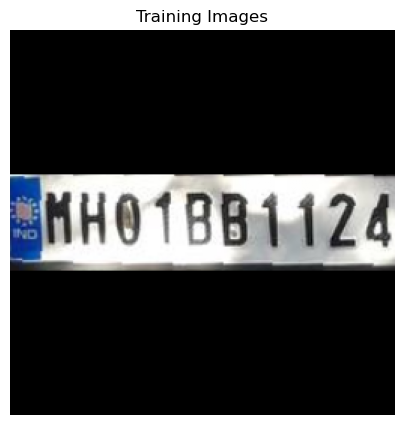

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[0], padding=5, normalize=True).cpu(),(1,2,0)))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Network
class Generator(nn.Module):
    def __init__(self,gpu):
        super(Generator, self).__init__()
        self.gpu=gpu

        self.main = nn.Sequential(
            # input is Z, going into a transposed convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 128 x 128
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device == 'cuda') and (ngpu > 1):
     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

In [12]:
class Discriminator(nn.Module):
    def __init__(self,gpu):
        super(Discriminator, self).__init__()
        self.gpu=gpu
        
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # input is (nc) x 128 x 128
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # input is (nc) x 64 x 64
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 8,affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(25

In [14]:
netD=Discriminator(ngpu).to(device)
netG=Generator(ngpu).to(device)

In [15]:
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)

optimizerD=torch.optim.Adam(netD.parameters(),lr=learning_rate)
optimizerG=torch.optim.Adam(netG.parameters(),lr=learning_rate)

In [16]:
def gradient_penalty(netD,images,fake,device='cpu'):
        BATCH_SIZE, C, H, W = images.shape
        alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)

        if(images.shape[0]!=batch_size):
            return 1.5

        interpolated_images = images * alpha + fake * (1 - alpha)

        # Calculate critic scores
        mixed_scores = netD(interpolated_images)

        # Take the gradient of the scores with respect to the images
        gradient = torch.autograd.grad(
          inputs=interpolated_images,
          outputs=mixed_scores,
          grad_outputs=torch.ones_like(mixed_scores),
          create_graph=True,
          retain_graph=True,
        )[0]

        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

        #print(gradient_penalty)
        return gradient_penalty

In [17]:
import os

path = '/kaggle/working//fake_images_plates'
try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  

In [18]:
num_steps=len(dataloader)
num_steps

37

In [19]:
num_steps=len(dataloader)
iters=0
count=0

img_list_real=[]
img_list_fake=[]

for epoch in range(num_epochs):
    for i,data in enumerate(dataloader,0):
        #real images
        images=data[0]
        images=images.to(device)
        #print(images.shape)

        #DISCRIMINATOR
        for c in range(clipping):
            netD.zero_grad()

            output_real=netD(images).reshape(-1)

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)

            output_fake=netD(fake).reshape(-1)

            gp=gradient_penalty(netD,images,fake,device)
            errD=-(torch.mean(output_real)-torch.mean(output_fake))+lambda_gp*gp

            errD.backward(retain_graph=True)
            optimizerD.step()

            #clipping of weights
            # for p in netD.parameters():
            #     p.data.clamp_(-0.01,0.01)

        #GENERATOR
        netG.zero_grad()

        output_gen=netD(fake).reshape(-1)

        errG=-torch.mean(output_gen)

        errG.backward()
        optimizerG.step()

        
        if((i+1)%30==0):
            print(f'\nEpoch [{epoch+1}/{num_epochs}]  Step [{i+1}/{num_steps}]  Discriminator Loss: {errD:.4f}  Generator Loss: {errG:.4f}')
            #print(f'Accuracy of Discriminator: {D_x:.4f}')
            #print(f'probability of Discriminator predicting: {D_G_z1:.4f} / {D_G_z2:.4f}')


        if(epoch == num_epochs-1):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()

            #saving the fake images generated in last epoch
            grid=utils.make_grid(fake, nrow=8, padding=2, normalize=True)
            img_list_fake.append(grid)
            
            if(device=='cuda'):
                torch.cuda.empty_cache()

            for temp in range(len(fake)):
                utils.save_image(utils.make_grid(fake[temp], padding=2, normalize=True), f"/kaggle/working/fake_images_plates/image_{epoch+1}_{count+1}.png")
                count+=1
        # else:
        #     with torch.no_grad():
        #         fake=netG(noise)

        #         #putting the fake images in a grid for demo purpose
        #         grid=utils.make_grid(fake, nrow=8, padding=2, normalize=True)
        #         img_list_fake.append(grid)

        iters+=1


Epoch [1/150]  Step [30/37]  Discriminator Loss: -304.4551  Generator Loss: 162.2863

Epoch [2/150]  Step [30/37]  Discriminator Loss: -407.7725  Generator Loss: 209.3421

Epoch [3/150]  Step [30/37]  Discriminator Loss: -344.5108  Generator Loss: 210.5997

Epoch [4/150]  Step [30/37]  Discriminator Loss: -264.4146  Generator Loss: 143.1469

Epoch [5/150]  Step [30/37]  Discriminator Loss: -209.6012  Generator Loss: 151.4165

Epoch [6/150]  Step [30/37]  Discriminator Loss: -217.2513  Generator Loss: 224.6019

Epoch [7/150]  Step [30/37]  Discriminator Loss: -181.0493  Generator Loss: 122.5833

Epoch [8/150]  Step [30/37]  Discriminator Loss: -210.9155  Generator Loss: 185.1184

Epoch [9/150]  Step [30/37]  Discriminator Loss: -183.4567  Generator Loss: 242.0828

Epoch [10/150]  Step [30/37]  Discriminator Loss: -126.9719  Generator Loss: 184.0847

Epoch [11/150]  Step [30/37]  Discriminator Loss: -175.0437  Generator Loss: 205.4757

Epoch [12/150]  Step [30/37]  Discriminator Loss: -

torch.Size([6, 3, 256, 256])


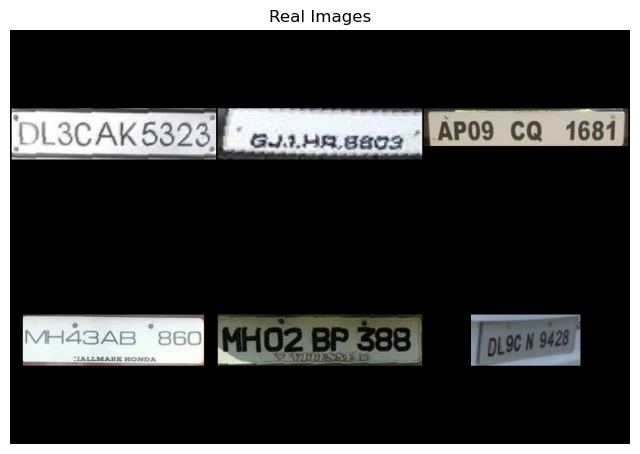

In [20]:
dataloader1=torch.utils.data.DataLoader(dataset, batch_size=6,shuffle=True)
real_batch = next(iter(dataloader1))
print(real_batch[0].shape)

# Plot the real images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0],nrow=3,padding=2,normalize=True).cpu(),(1,2,0)))

37
torch.Size([3, 8258, 2066])


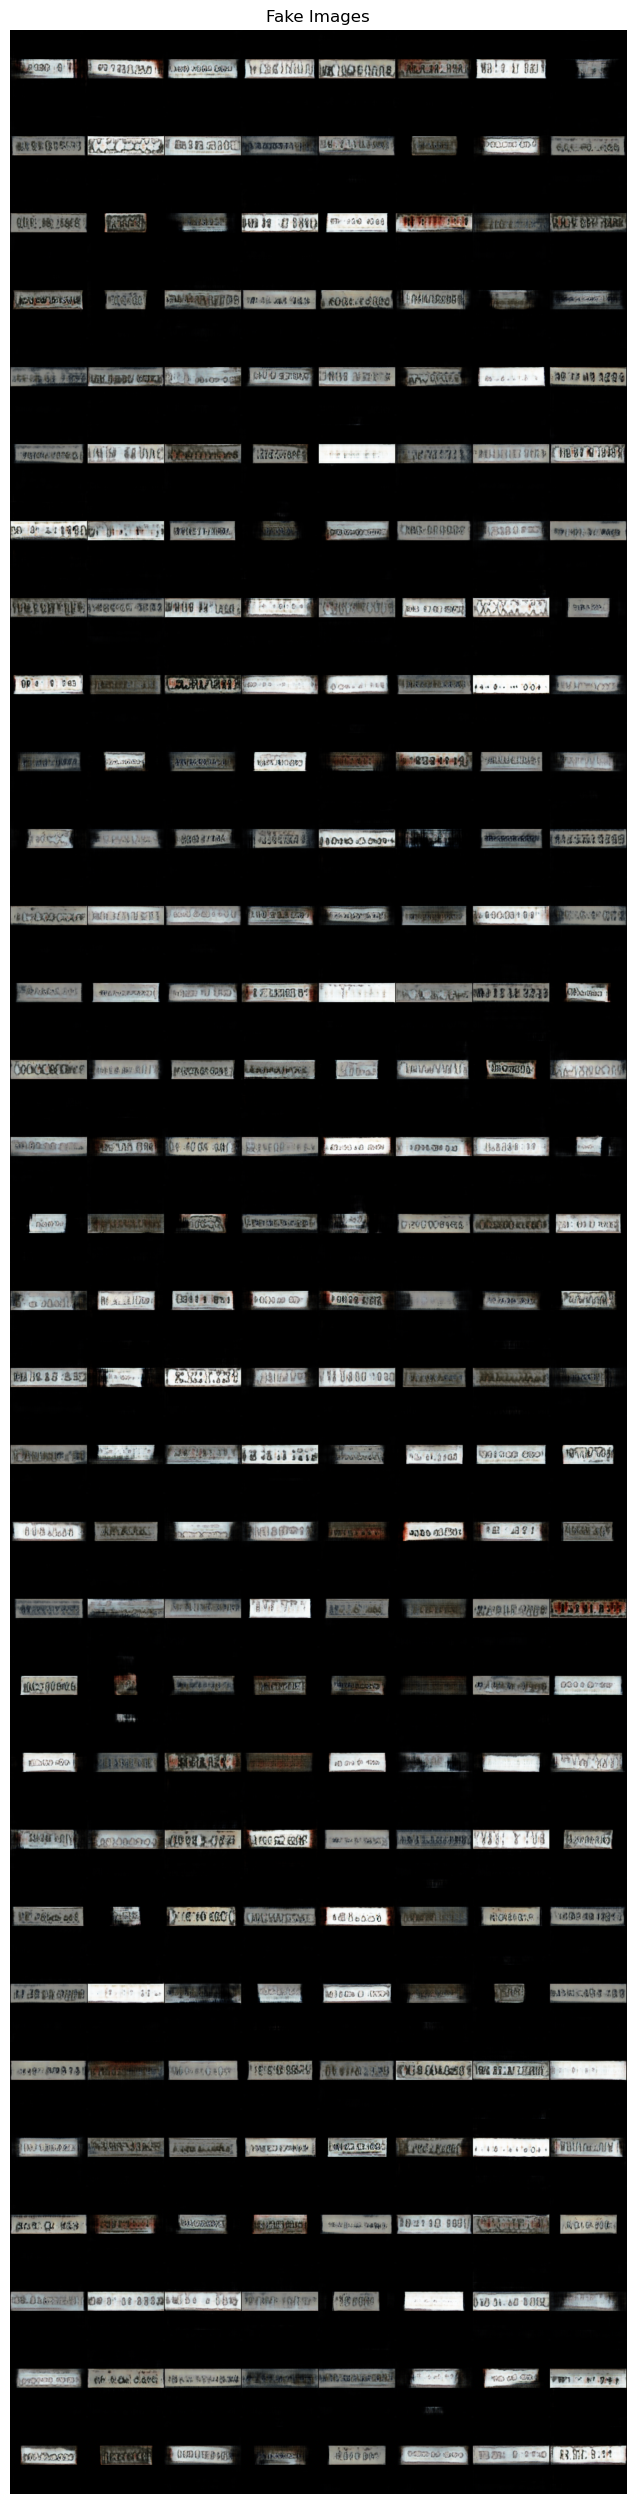

In [21]:
# Plot the fake images from the last epoch
print(len(img_list_fake))
print(img_list_fake[0].shape)

img_list_fake[0]=img_list_fake[0].to(device)

plt.figure(figsize=(32,32))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list_fake[0].cpu(),(1,2,0)))
plt.show()

In [22]:
!tar -zcvf '/kaggle/working/fake_images_plates.tar.gz' '/kaggle/working/fake_images_plates'

from IPython.display import clear_output
clear_output()